In [80]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import Aer

from scipy.optimize import minimize
from MSA import MultipleSequenceAlignment

In [81]:
def get_Aer_backend(name: str):
    """Function for retrieving specified Aer backend
    Possible backends include:
    
    "aer_simulator", "aer_simulator_statevector","aer_simulator_density_matrix",
    "aer_simulator_stabilizer","aer_simulator_matrix_product_state",
    "aer_simulator_extended_stabilizer","aer_simulator_unitary",
    "aer_simulator_superop","qasm_simulator,statevector_simulator",
    "unitary_simulator","pulse_simulator"

    Parameters:
    -----------
        name: string - name of chosen Aer qiskit backend

    Returns:
    --------
        my_backend: qiskit.providers.aer.backends - chosen backend
    """
    return Aer.get_backend(name)

def compute_Q_edges(Q: np.ndarray) -> np.ndarray:
    """ Function for computing edges from Q matrix in QUBO
    
    Parameters:
    -----------
        Q: np.ndarray - 2D numpy array containing weights in Q matrix from QUBO
    
    Returns:
    --------
       edges: np.ndarray - 1D numpy array of triplets np.array([(i_1,j_1,w_i1j1),(i_2,j_2,w_i2j2),...])

    """

    edges = [] 
    for idx1 in range(Q.shape[1]):
        for idx2 in range(Q.shape[0]):
            if Q[idx1][idx2] != 0:
                edges.append((idx1,idx2,Q[idx1][idx2]))
    return edges

def string_to_arr(string: str) -> np.ndarray:
    """Funtion for transforming given string of integers
       to corresponding array of ints

    Parameters:
    -----------
        string: str - a string of ints, e.g.: '001100'   

    Returns:
    --------
        arr: np.ndarray - numpy array of ints, e.g.: np.array([0,0,1,1,0,0])
    """

    arr = []
    for str in string: arr.append(int(str))
    return np.array(arr).reshape((len(np.array(arr)),1))
    


In [102]:
def create_qaoa_circ(my_MSA, theta, normalize_weights=True):
    
    """
    Creates a parametrized qaoa circuit

    """
    letters_in_mat = [my_MSA.initial_MSA[i][j] for i in range(my_MSA.initial_MSA.shape[0]) 
                      for j in range(my_MSA.initial_MSA.shape[1]) if my_MSA.initial_MSA[i][j] != "_"]
    
    nqubits = int(len(letters_in_mat) *  my_MSA.initial_MSA.shape[1])  # Number of qubits = number of nodes in graph 
    p       = len(theta)//2                                            # Number of alternating unitaries
    qc      = QuantumCircuit(nqubits)                                  # Initializing Q circuit w. nqubits nr. of qbits

    beta  = theta[:p]                # Beta opt param for mixing unitaries as first p vals.
    gamma = theta[p:]                # Gama opt param for cost unitaries as last p vals.
    
    p1, p2, p3 = my_MSA.penalties[0],  my_MSA.penalties[1],  my_MSA.penalties[2]

    Q, h, d    = my_MSA.QUBO_model[0], my_MSA.QUBO_model[1], my_MSA.QUBO_model[2]

    if normalize_weights:
        Q *= 1./np.max(np.array([np.max(Q),np.max(h)]))
        h *= 1./np.max(np.array([np.max(Q),np.max(h)]))

    edges = compute_Q_edges(Q)

    # Initial_state: Hadamark gate on each qbit
    for i in range(0, nqubits):
        qc.h(i)
    
    # Cost unitary:
    for irep in range(0, p):        
        for i, j, w_ij in edges:
            if i!= j:
                qc.rzz(2 * gamma[irep] * w_ij , i , j)
            else:
                qc.rz(2 * gamma[irep] * w_ij      , i) # Diagonal in Q matrix
                qc.rz(2 * gamma[irep] * h[i] * p1 , i) # Elements of h vector

    # Mixer unitary: X rotation on each qbit      
    for irep in range(0, p): 
        for i in range(0, nqubits):
            qc.rx(1 * beta[irep], i)
            
    qc.measure_all()        
    return qc

def compute_expectation(my_MSA: np.ndarray, counts, normalize_weights) -> float:
    
    """
    Computes expectation value based on measurement results

    """
    Q, h, d = my_MSA.QUBO_model[0], my_MSA.QUBO_model[1], my_MSA.QUBO_model[2]

    if normalize_weights:
        Q *= 1./np.max(np.array([np.max(Q),np.max(h)]))
        h *= 1./np.max(np.array([np.max(Q),np.max(h)]))

    sum_count, avg = 0, 0
    for bitstring, count in counts.items():
        state = string_to_arr(bitstring)
        score = ((state.T @ (Q @ state)) + (h.T @ state) + d)[0][0]
        avg  += score * count
        sum_count += count
    return avg/sum_count

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(my_MSA: np.ndarray, normalize_weights = True, shots=512):
    
    """
    Runs parametrized circuit
    
    """
    #backend = StatevectorSimulator(precision="double")
    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(my_MSA, theta, normalize_weights=normalize_weights)
        #qc = qc.decompose()
        #qc = transpile(qc,optimization_level=3)
        counts = backend.run(qc,seed_simulator=10).result().get_counts()
        return compute_expectation(my_MSA,counts, normalize_weights) ## Returns the expectation of graph, given counts
    
    return execute_circ

def plot_count_histogram(counts, solutions):
    import matplotlib.pyplot as plt

    plt.rc("font", family=["Helvetica", "Arial"])
    plt.rc("text", usetex=True)
    plt.rc("xtick", top=True, direction="in")
    plt.rc("ytick", right=True, direction="in")
    
    ## Getting values 
    initial_states = np.array(list(counts.keys()))
    initial_counts = np.array(list(counts.values()))

    ## Sorting
    initial_counts = np.array([count/np.sum(initial_counts) for count in initial_counts])
    nr_ones = [np.sum(string_to_arr(initial_states[i]).flatten()) for i in range(len(initial_states))]
    sorted_states = initial_states[np.argsort(nr_ones)]
    sorted_counts = initial_counts[np.argsort(nr_ones)]

    ## Setting idx for states if present in solutions
    good_indexes = []
    for solution in solutions:
        for idx, state in enumerate([string_to_arr(sorted_states[i]).flatten() for i in range(len(sorted_states))]):
            equal = True
            for int_idx, integer in enumerate(state.astype(np.float64)):
                if integer != solution[int_idx]:
                    equal = False
            if equal: good_indexes.append(idx)

    ## Plotting
    fig, ax = plt.subplots(1,1,figsize=(25,6))

    xs = np.arange(0,len(sorted_states))
    x_labels = [r"$|$"+state+r"$\rangle$" for state in sorted_states]
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels, rotation = 90,size=15)
    bar = ax.bar(sorted_states,sorted_counts,color=["tab:red" if i in good_indexes else "tab:blue" for i in range(len(xs))],label="Red is valid solutions")

    for idx, rect in enumerate(bar):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{sorted_counts[idx]:.3f}', ha='center', va='bottom')

    ax.set_ylabel("Probability",size=18)
    ax.legend()
    plt.show()


In [125]:
my_strings   = np.array(["AG","G"])
my_penalties = np.array([1,1,1])*2
my_msa       = MultipleSequenceAlignment(strings = my_strings, penalties = my_penalties) 

solutions = [my_msa.initial_bitstring,np.array([1,0,0,1,0,1],dtype=np.float64)]

In [126]:
shots = 512
p = 1
theta_0 = np.ones(p)
expectation = get_expectation(my_MSA = my_msa, normalize_weights=True, shots = shots)
options = {"disp":True,"maxiter": 1000}
res = minimize(fun = expectation, x0 = theta_0, method='COBYLA',options = options)
res

     fun: -3.524658203125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 7
  status: 1
 success: True
       x: array([1.])


   Normal return from subroutine COBYLA

   NFVALS =    7   F =-3.524658E+00    MAXCV = 0.000000E+00
   X = 1.000000E+00


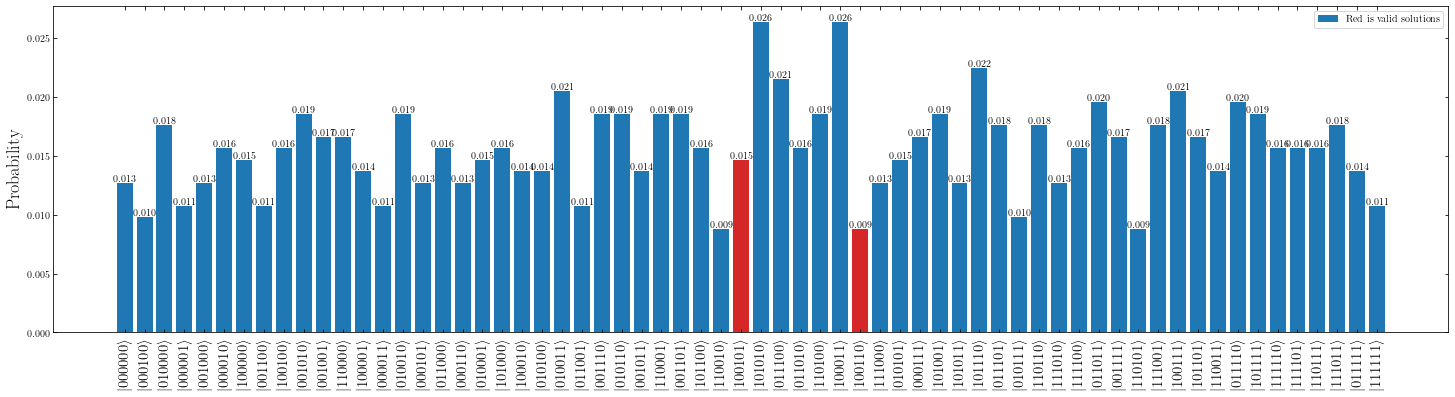

In [127]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
#backend = StatevectorSimulator(precision="double")
backend.shots = shots

qc = create_qaoa_circ(my_MSA=my_msa,theta = res.x, normalize_weights=True)
#qc = qc.decompose()
#qc = transpile(qc,optimization_level=3)

counts = backend.run(qc,seed_simulator=10).result().get_counts()

plot_count_histogram(counts,solutions)

In [104]:
def get_solutions(lim: int, counts):
    idxs = np.flip(np.argsort(list(counts.values())))
    return np.array(list(counts.keys()))[idxs][:lim]

best_solutions = get_solutions(len(list(counts.values())),counts)
states = [string_to_arr(solution) for solution in best_solutions]
idx = 4
print(states[idx])
print(my_msa.bit_state_2_matrix(states[idx]))

[[1]
 [0]
 [0]
 [1]
 [0]
 [1]]
[['A' 'G']
 ['_' 'G']]
